# V3 - add ensemble stuff from 
- https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
- Conclusion: ensemble stuff seems to be overfitting: training score 87% accuracy, test is <80%
Could squeak out a few more points from adding more options to grid search optimization, and further feature ne

# Titanic Machine Learning

This notebook is my first attempt at the Titanic Challenge. Version I was based off https://www.kaggle.com/startupsci/titanic-data-science-solutions and https://www.kaggle.com/omarelgabry/a-journey-through-titanic. These tutorials relied on in-sample prediction and therefore performed poorly in out-of-sample (and test submisssion) prediction. 

Version 2 follows largely from https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy

## TODO
- More testing with feature engineering
    - M/F/Child
    - Smarter binning of values
    - Getting location from Ticket? 
- Better understand feature selection, etc. 
- Is it possible to train the model on ALL the training data (rather than do feature selection, etc?)
    - the learning curves may suggest otherwise
- Etc: outlier removal (or top-coding)


## CLARIFY
I still don't quite understand why the splitting in the tutorial is 60%-30%, rather than 60-40. Look into the train and test scores and what they mean. 
    - http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
    - because the tutorial diagram makes it seem like it would be 60-30...

## Next steps/questions for exploration
- FIXME - having trouble installing xgboost
- Which scikit-learn algorithms have regularization built-in? (or is that a setting?)
- How can I design a learning curve? 
- which analytic methods can handle nonlinear relationships in features WITHOUT binning? I don't like turning fare and age into arbitrary bins
- need to remove one level of dummy. Is there a clever way to do it in the generalized function? Like see which dummy has the lowest (or most negative) correlation with the outcome? 
- Some other things to look into: 
    - http://datascience.stackexchange.com/questions/10805/does-scikit-learn-use-regularization-by-default/10806
    - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    - http://stackoverflow.com/questions/20463281/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn
    - http://stats.stackexchange.com/questions/111968/random-forest-how-to-handle-overfitting
    - http://scikit-learn.org/stable/modules/feature_selection.html
    - https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python	

### In general, how do I get a better workflow for testing feature & model selection, etc? Basically, I need to wrap the data processing into a manageable script, and have measures of in-sample and out-of-sample accuracy. Ideally a learning curve as well

In [1]:
# TODO - use Kaggle API
# pip install kaggle
# kaggle competitions download -c titanic

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
!date

Tue Mar 27 20:30:34 PDT 2018


In [3]:
# machine learning
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC, LinearSVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import Perceptron
# from sklearn.linear_model import SGDClassifier
# from sklearn.tree import DecisionTreeClassifier


#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
#from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Helpful functions

In [4]:
def bin_feature(df, feature, bins, visualize = False):
    df[f'{feature}Bin'] = pd.cut(df[feature], bins, right = False)
    df[f'{feature}Bin_Code'] = pd.cut(df[feature], bins, right = False, labels=list(range(0,len(bins) - 1)))
    
    assert(pd.isna(df[f'{feature}Id']).sum() == 0), f'NAs created by binning {feature}, check bins'
    
    if visualize:
        print(df[[f'{feature}Id', 'Survived']].groupby([f'{feature}Id'], as_index=False).mean().sort_values(by=f'{feature}Id', ascending=True))
        grid = sns.FacetGrid(df_train, size=5)
        grid.map(sns.pointplot, f'{feature}Id', 'Survived', 'Sex', palette='deep')
        grid.add_legend()
    
    return df

def make_feature_dummies(df, feature):
    dummies = pd.get_dummies(df[feature], prefix = feature)
    df = df.merge(dummies, left_index=True, right_index = True)
    return df
    
def count_missing_features(df):
    print(f'features with missing obs (n = {len(df.index)})')
    for col in df.columns:
        n_miss = pd.isna(df[col]).sum()
        if n_miss > 0: print(f'_{col}_ {n_miss}')
            
def check_for_any_na(df):
    missing_features = pd.isna(df).sum()
    n_miss = missing_features.sum() 
    if n_miss > 0: print(missing_features[missing_features > 0])
    assert (n_miss == 0), 'df has missing values'

In [5]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
print(df_train.columns.values)
df_train.head()

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Quick Examination of data

In [6]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
df_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Panula, Mrs. Juha (Maria Emilia Ojala)",male,347082,B96 B98,S
freq,1,577,7,4,644


In [8]:
print("df_train")
count_missing_features(df_train) 
print('_'*40)
print("df_test")
count_missing_features(df_test) 

df_train
features with missing obs (n = 891)
_Age_ 177
_Cabin_ 687
_Embarked_ 2
________________________________________
df_test
features with missing obs (n = 418)
_Age_ 86
_Fare_ 1
_Cabin_ 327


# Visualize Data
## Basic Demographics

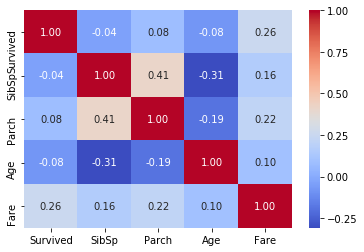

In [9]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(df_train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

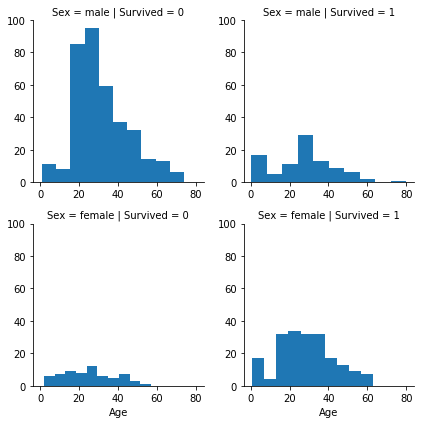

In [10]:
g = sns.FacetGrid(df_train, row = 'Sex', col='Survived')
g.map(plt.hist, 'Age', bins=10)
#g = sns.FacetGrid(df_train, row = 'Sex', col='Survived', hue = 'Pclass')
#g.map(sns.distplot, 'Age', bins=10, hist = False)
#g.add_legend()

## Survival by Class and Embarked

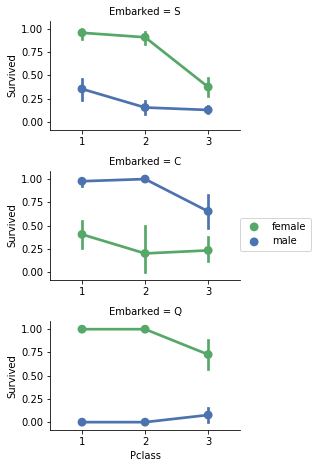

In [11]:
grid = sns.FacetGrid(df_train, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

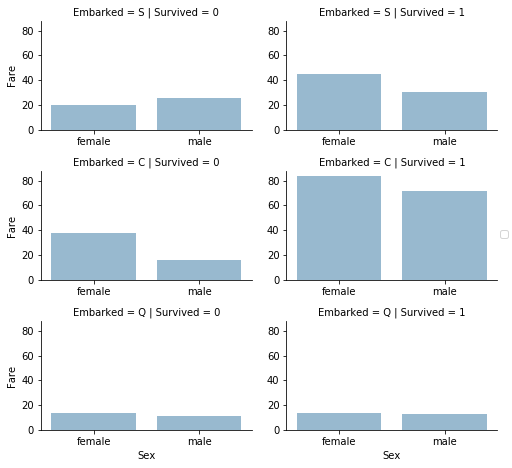

In [12]:
grid = sns.FacetGrid(df_train, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

# Complete Missing features
For now, just use overall median/mode. Further analyses can examine improvement by more complex imputation 

In [13]:
df_both = [df_train, df_test]

for dataset in df_both:    
    #complete missing age with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)
    dataset['Age'] = dataset['Age'].astype(int)

    #complete embarked with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    #complete missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
    
# More complex imputation: imputing mean age by stratification. 

# grid = sns.FacetGrid(df_train, row='Pclass', col='Sex', size=2.2, aspect=1.6)
# #grid = sns.FacetGrid(df_train, row='Title', col='Sex', size=2.2, aspect=1.6)
# grid.map(plt.hist, 'Age', alpha=.5, bins=20)
# grid.add_legend()

# guess_ages = np.zeros((2,3))

# df_both = [df_train, df_test]
# for dataset in df_both:
#     for i in range(0, 2):
#         for j in range(0, 3):
#             guess_df = dataset[(dataset['Sex'] == i) & \
#                                   (dataset['Pclass'] == j+1)]['Age'].dropna()

#             # age_mean = guess_df.mean()
#             # age_std = guess_df.std()
#             # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

#             age_guess = guess_df.median()

#             # Convert random age float to nearest .5 age
#             guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
#     for i in range(0, 2):
#         for j in range(0, 3):
#             dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
#                     'Age'] = guess_ages[i,j]

#     dataset['Age'] = dataset['Age'].astype(int)


# Feature Engineering
- `Title` from `Name`
- `FamilySize` from `SibSp` and `Parch`
- `cabin` needs some TLC

In [14]:
#NOTE - quick analysis shows no difference between Mrs and Miss, so lump them together
title_mapping = {"Mr": "Mr", 
                 "Miss": "Miss", "Ms":"Miss", "Mlle": "Miss",
                 "Mrs": "Miss", "Mme": "Miss",
                 "Master": "Master"}

df_both = [df_train, df_test]
for dataset in df_both:
    dataset['Prefix'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # Potentially cleaner way (TODO: check that they produce same result)
    # dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

    dataset['Title'] = dataset['Prefix'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna("Other")
    
df_test = make_feature_dummies(df_test, 'Title')
df_train = make_feature_dummies(df_train, 'Title')

# Convert to ordinal
# title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
# for dataset in df_both:
#     dataset['Title'] = dataset['Title'].map(title_mapping)
#     dataset['Title'] = dataset['Title'].fillna(0)

# pd.crosstab(df_train['Title'], df_train['Survived'], dropna = False)

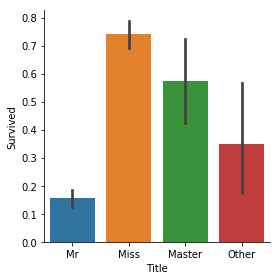

In [15]:
g = sns.factorplot(x="Title",y="Survived",data=df_train,kind="bar")

In [16]:
df_both = [df_train, df_test]
for dataset in df_both:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
    dataset['IsAlone'] = 1 #initialize to yes/1 is alone
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1
    
# df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean() #.sort_values(by='Survived', ascending=False)

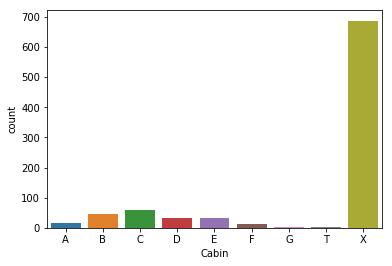

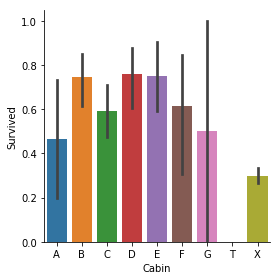

In [17]:
# If passenger is missing cabin information, assume they're on deck. 
# Cursory analysis shows large survival difference between deck and cabins, but with small samples of each cabin no differences between
for dataset in [df_train, df_test]: 
    dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])
g = sns.countplot(df_train["Cabin"],order=['A','B','C','D','E','F','G','T','X'])
g = sns.factorplot(y="Survived",x="Cabin",data=df_train,kind="bar",order=['A','B','C','D','E','F','G','T','X'])

df_test = pd.get_dummies(df_test, columns = ["Cabin"],prefix="Cabin") #NOTE we will just want Cabin_X 
df_train = pd.get_dummies(df_train, columns = ["Cabin"],prefix="Cabin") #NOTE we will just want Cabin_X 

## Bin Relevant Features

In [18]:
# equal bins (via basic pd functions)
for dataset in [df_train, df_test]:
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)
    dataset['FamilySizeBin'] = pd.cut(dataset['FamilySize'], bins = [1, 2, 5, 20], right = False)

# Custom bins (via my convenience function)

# Seems like 4 or less survive more (guessing it's a socioeconomic thing)
# BUT lonely males are not well off

# bins = [1, 2, 5, 20]
# df_train = bin_feature(df_train, 'FamilySize', bins, visualize=False)
# df_test = bin_feature(df_test, 'FamilySize', bins, visualize=False)

# bins = [0,12,50,120]
# df_train = bin_feature(df_train, 'Age', bins, convert_to_id = False, visualize=True)
# df_test = bin_feature(df_test, 'Age', bins, convert_to_id = False, visualize=False)

# # Visualize survival by age
# fig, axis1 = plt.subplots(1,1,figsize=(22,4))
# average_age = df_train[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
# sns.barplot(x='Age', y='Survived', data=average_age)

## Transform 
- In future, try log-transforming, rather than binning, fare
`dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)`

## Make dummy variables (maybe later...)

In [19]:
#NOTE - I was having trouble looping over the dataframes in the function. Maybe a reference vs copy issue

# df_train = make_feature_dummies(df_train, 'FamilySizeId')
# df_test = make_feature_dummies(df_test, 'FamilySizeId')

# df_train = make_feature_dummies(df_train, 'AgeId')
# df_test = make_feature_dummies(df_test, 'AgeId')

# df_train = make_feature_dummies(df_train, 'Embarked')
# df_test = make_feature_dummies(df_test, 'Embarked')

## Encode categorical features

In [20]:
label = LabelEncoder()
for dataset in [df_train, df_test]:    
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])
    dataset['FamilySizeBin_Code'] = label.fit_transform(dataset['FamilySizeBin'])

    #dataset['Sex_Code'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

# Define analytic features

In [21]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Prefix', 'Title',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Other', 'FamilySize',
       'IsAlone', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_X', 'FareBin', 'AgeBin',
       'FamilySizeBin', 'Sex_Code', 'Embarked_Code', 'Title_Code',
       'AgeBin_Code', 'FareBin_Code', 'FamilySizeBin_Code'],
      dtype='object')

In [22]:
#define y variable aka target/outcome
Target = ['Survived']

data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code', 'Cabin_X']
# TODO: check using FamilySizeBin, Is_Alone, and other dummies/ custom bins!


# FamilySizeDummies = list(filter(lambda x:'FamilySizeId_' in x, df_train.columns.values.tolist()))
# AgeDummies = list(filter(lambda x:'AgeId_' in x, df_train.columns.values.tolist()))
# EmbarkedDummies = list(filter(lambda x:'Embarked_' in x, df_train.columns.values.tolist()))
# TitleDummies = list(filter(lambda x:'Title_' in x, df_train.columns.values.tolist()))
# dummies = FamilySizeDummies + AgeDummies + EmbarkedDummies + TitleDummies
# dummies

In [23]:
check_for_any_na(df_train[data1_x_bin])
check_for_any_na(df_test[data1_x_bin])

In [24]:
df_train[data1_x_bin].head()

,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code,Cabin_X
0,1,3,2,2,2,1,0,1
1,0,1,0,1,2,2,3,0
2,0,3,2,1,1,1,1,1
3,0,1,2,1,2,2,3,0
4,1,3,2,2,1,2,1,1


In [25]:
data1 = df_train

In [26]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    #XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data1[Target]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data1[data1_x_bin], data1[Target], cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(data1[data1_x_bin], data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.829588,0.830224,0.046761,0.112205
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.835206,0.829851,0.0436997,0.101036
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.86985,0.829478,0.0581767,0.13415
8,RidgeClassifierCV,"{'alphas': (0.1, 1.0, 10.0), 'class_weight': N...",0.826404,0.825373,0.0471746,0.00444918
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.853933,0.825373,0.0563717,0.00288668
19,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.826217,0.824627,0.0500612,0.00405138
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.823783,0.823507,0.0500737,0.201129
16,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.825468,0.822388,0.0525524,0.0626182
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.894757,0.822388,0.0575595,0.0330056
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.872285,0.819403,0.0555657,0.842947


Text(0,0.5,'Algorithm')

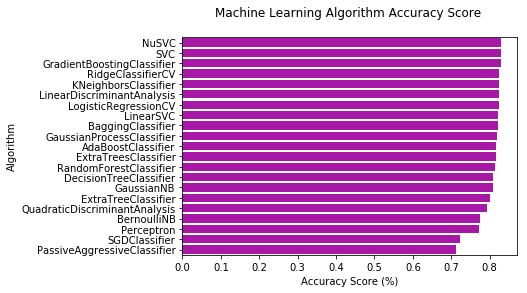

In [27]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

# Plot learning curves
https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

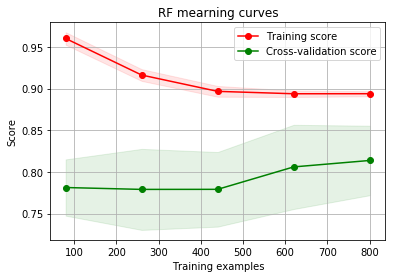

In [28]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10)

from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

estimator = tree.DecisionTreeClassifier().fit(data1[data1_x_bin], data1[Target])
g = plot_learning_curve(estimator,"RF mearning curves",data1[data1_x_bin], data1[Target],cv=kfold)

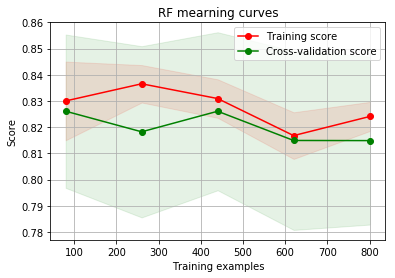

In [29]:
estimator = linear_model.LogisticRegressionCV().fit(data1[data1_x_bin], data1[Target])
g = plot_learning_curve(estimator,"RF mearning curves",data1[data1_x_bin], data1[Target],cv=kfold)

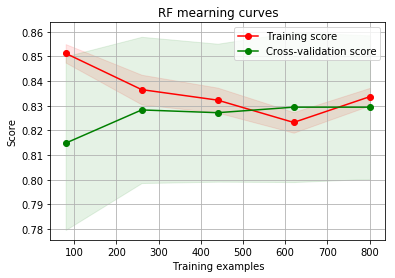

In [30]:
estimator = svm.SVC(probability=True).fit(data1[data1_x_bin], data1[Target])
g = plot_learning_curve(estimator,"RF mearning curves",data1[data1_x_bin], data1[Target],cv=kfold)

## Tune DecisionTree hyperparameters
https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy

In [31]:
#base model
dtree = tree.DecisionTreeClassifier(random_state = 0)
base_results = model_selection.cross_validate(dtree, data1[data1_x_bin], data1[Target], cv  = cv_split)
dtree.fit(data1[data1_x_bin], data1[Target])

print('BEFORE DT Parameters: ', dtree.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
#print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)


#tune hyper-parameters: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
             }

#print(list(model_selection.ParameterGrid(param_grid)))

#choose best model with grid_search: #http://scikit-learn.org/stable/modules/grid_search.html#grid-search
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
tune_model.fit(data1[data1_x_bin], data1[Target])

#print(tune_model.cv_results_.keys())
#print(tune_model.cv_results_['params'])
print('AFTER DT Parameters: ', tune_model.best_params_)
#print(tune_model.cv_results_['mean_train_score'])
print("AFTER DT Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(tune_model.cv_results_['mean_test_score'])
print("AFTER DT Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)



BEFORE DT Parameters:  {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
BEFORE DT Training w/bin score mean: 90.09
BEFORE DT Test w/bin score mean: 80.97
BEFORE DT Test w/bin score 3*std: +/- 4.39
----------
AFTER DT Parameters:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 0.05, 'random_state': 0, 'splitter': 'random'}
AFTER DT Training w/bin score mean: 90.64
AFTER DT Test w/bin score mean: 87.78
AFTER DT Test w/bin score 3*std: +/- 7.13
----------


In [ ]:
## Use feature selection as per https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy

In [34]:
#base model
print('BEFORE DT RFE Training Shape Old: ', data1[data1_x_bin].shape) 
print('BEFORE DT RFE Training Columns Old: ', data1[data1_x_bin].columns.values)

print("BEFORE DT RFE Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT RFE Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)



#feature selection
dtree_rfe = feature_selection.RFECV(dtree, step = 1, scoring = 'accuracy', cv = cv_split)
dtree_rfe.fit(data1[data1_x_bin], data1[Target])

#transform x&y to reduced features and fit new model
#alternative: can use pipeline to reduce fit and transform steps: http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
X_rfe = data1[data1_x_bin].columns.values[dtree_rfe.get_support()]
rfe_results = model_selection.cross_validate(dtree, data1[X_rfe], data1[Target], cv  = cv_split)

#print(dtree_rfe.grid_scores_)
print('AFTER DT RFE Training Shape New: ', data1[X_rfe].shape) 
print('AFTER DT RFE Training Columns New: ', X_rfe)

print("AFTER DT RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100)) 
print("AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print("AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))
print('-'*10)


#tune rfe model
rfe_tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
rfe_tune_model.fit(data1[X_rfe], data1[Target])

#print(rfe_tune_model.cv_results_.keys())
#print(rfe_tune_model.cv_results_['params'])
print('AFTER DT RFE Tuned Parameters: ', rfe_tune_model.best_params_)
#print(rfe_tune_model.cv_results_['mean_train_score'])
print("AFTER DT RFE Tuned Training w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(rfe_tune_model.cv_results_['mean_test_score'])
print("AFTER DT RFE Tuned Test w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT RFE Tuned Test w/bin score 3*std: +/- {:.2f}". format(rfe_tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE DT RFE Training Shape Old:  (891, 8)
BEFORE DT RFE Training Columns Old:  ['Sex_Code' 'Pclass' 'Embarked_Code' 'Title_Code' 'FamilySize'
 'AgeBin_Code' 'FareBin_Code' 'Cabin_X']
BEFORE DT RFE Training w/bin score mean: 90.09
BEFORE DT RFE Test w/bin score mean: 80.97
BEFORE DT RFE Test w/bin score 3*std: +/- 4.39
----------
AFTER DT RFE Training Shape New:  (891, 6)
AFTER DT RFE Training Columns New:  ['Pclass' 'Title_Code' 'FamilySize' 'AgeBin_Code' 'FareBin_Code' 'Cabin_X']
AFTER DT RFE Training w/bin score mean: 88.58
AFTER DT RFE Test w/bin score mean: 82.99
AFTER DT RFE Test w/bin score 3*std: +/- 4.94
----------
AFTER DT RFE Tuned Parameters:  {'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 0.03, 'random_state': 0, 'splitter': 'best'}
AFTER DT RFE Tuned Training w/bin score mean: 90.09
AFTER DT RFE Tuned Test w/bin score mean: 87.87
AFTER DT RFE Tuned Test w/bin score 3*std: +/- 7.11
----------


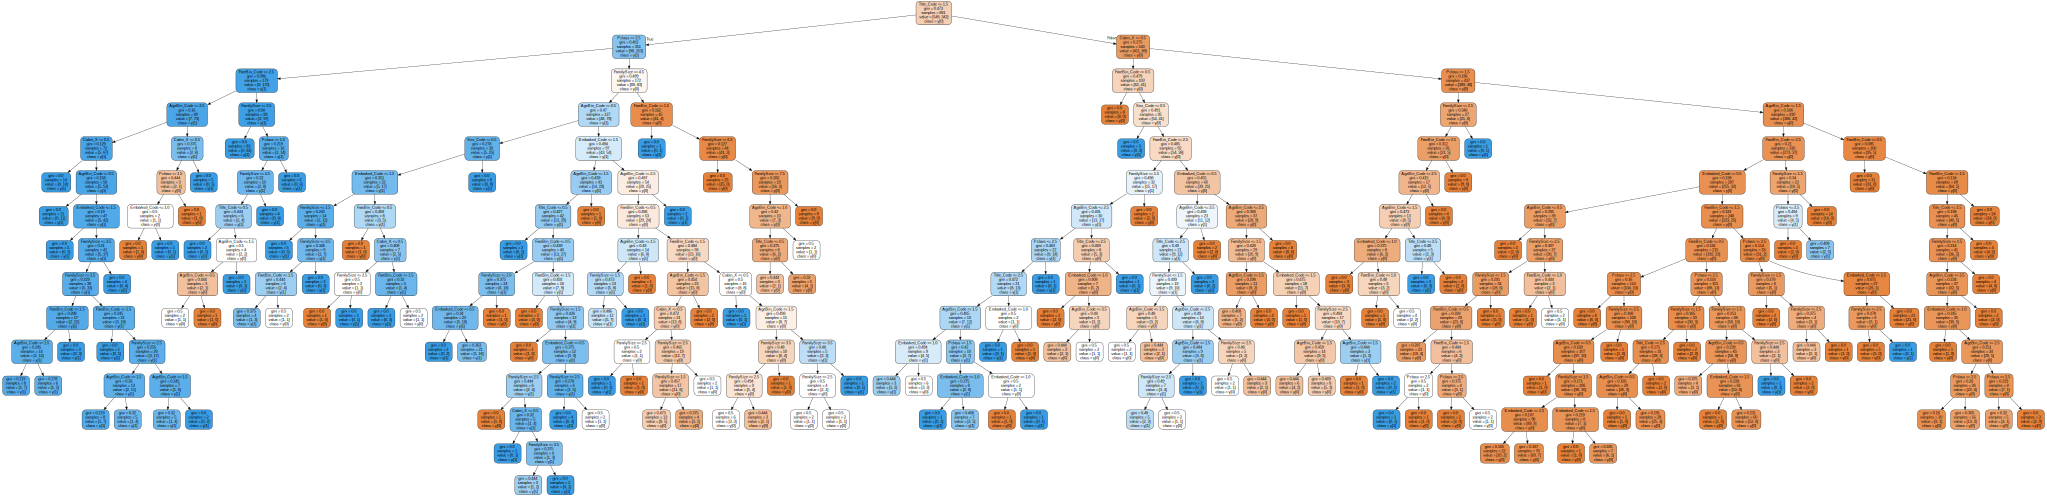

In [33]:
#Graph MLA version of Decision Tree: http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
import graphviz 
dot_data = tree.export_graphviz(dtree, out_file=None, 
                                feature_names = data1_x_bin, class_names = True,
                                filled = True, rounded = True)
graph = graphviz.Source(dot_data) 
graph

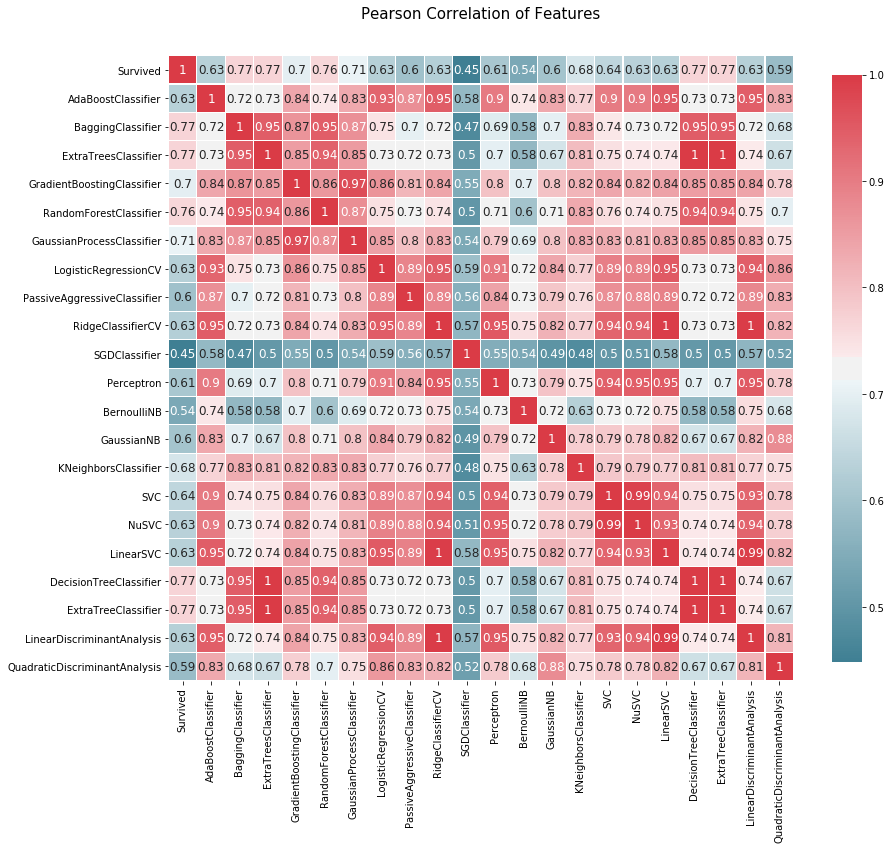

In [35]:
#compare algorithm predictions with each other, where 1 = exactly similar and 0 = exactly opposite
#there are some 1's, but enough blues and light reds to create a "super algorithm" by combining them
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(MLA_predict)

In [36]:
submit_dt = rfe_tune_model.fit(data1[X_rfe], data1[Target])
df_test['Survived'] = submit_dt.predict(df_test[X_rfe])
submission = df_test[['PassengerId', 'Survived']]
print(f'SANITY CHECK: mean survival in predictions is {submission["Survived"].mean()}')
submission.head()

SANITY CHECK: mean survival in predictions is 0.35167464114832536


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [37]:
submission.to_csv('./output/submission.csv', index=False)

## Try ensemble stacking methods from 
- https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
I performed a grid search optimization for AdaBoost, ExtraTrees , RandomForest, GradientBoosting and SVC classifiers.

I set the "n_jobs" parameter to 4 since i have 4 cpu . The computation time is clearly reduced.

But be carefull, this step can take a long time, i took me 15 min in total on 4 cpu.

In [52]:
# convert for easy use of different kernel
X_train = data1[data1_x_bin]
Y_train = data1[Target]
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [43]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Done 884 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    4.5s finished


In [45]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [0.8, 0.9, 1], #NOTE zrankin - it was [1, 3, 10], but needs to be float to be percentage of featutes. Setting high because already limited
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.5min finished


0.8294051627384961

In [46]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [0.8, 0.9, 1],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.7min finished


0.8327721661054994

In [47]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   17.9s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   34.9s finished


0.8282828282828283

In [48]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.4s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   41.5s finished


0.8338945005611672

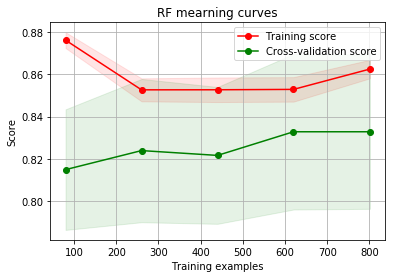

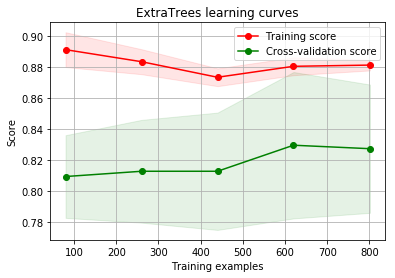

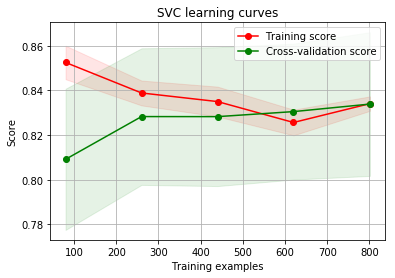

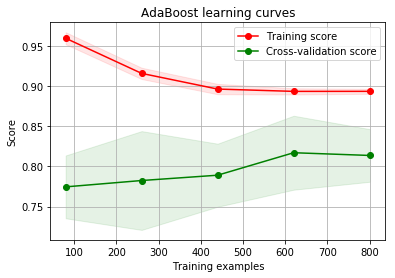

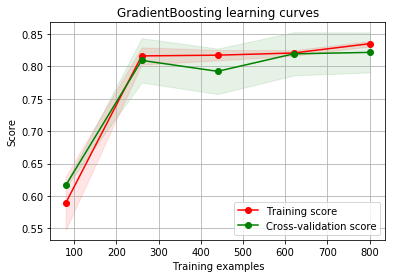

In [49]:
#Learning Curves
g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

GradientBoosting and Adaboost classifiers tend to overfit the training set. According to the growing cross-validation curves GradientBoosting and Adaboost could perform better with more training examples.

SVC and ExtraTrees classifiers seem to better generalize the prediction since the training and cross-validation curves are close together.

In [50]:
# FINAL ENSEMBLE PREDICTIONS

In [53]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

In [55]:
votingC.score(X_train, Y_train)

0.8742985409652076

In [56]:
df_test['Survived'] = votingC.predict(df_test[data1_x_bin])
submission = df_test[['PassengerId', 'Survived']]
print(f'SANITY CHECK: mean survival in predictions is {submission["Survived"].mean()}')
submission.head()

SANITY CHECK: mean survival in predictions is 0.3684210526315789


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [57]:
submission.to_csv('./output/ensemble_submission.csv', index=False)